# Modelo de Regresión para la Predicción de Accidentes de Tráfico en Madrid al día mediante Redes Neuronales Recurrentes
## Un Enfoque de Deep Learning para Análisis de Series Temporales

In [50]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
from keras.callbacks import EarlyStopping
from keras.layers import LeakyReLU
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from tensorflow.keras.layers import Dense, GRU, Input
from tensorflow.keras.models import Sequential
from keras.optimizers import Adam

In [51]:
df = pd.read_pickle("accidentes.pkl")

In [52]:
df.head()

accidente_id      fecha_completa      fecha   rango_horario   
0      2010.135 2010-01-01 00:00:00 2010-01-01 0 days 00:00:00  \
1      2010.135 2010-01-01 00:00:00 2010-01-01 0 days 00:00:00   
2      2010.135 2010-01-01 00:00:00 2010-01-01 0 days 00:00:00   
3      2010.940 2010-01-01 01:00:00 2010-01-01 0 days 01:00:00   
4      2010.940 2010-01-01 01:00:00 2010-01-01 0 days 01:00:00   

                                        localizacion numero   
0  calle de cartagena num                        ...    104  \
1  calle de cartagena num                        ...    104   
2  calle de cartagena num                        ...    104   
3  autovia  m-30 calzada 2 km.                   ...  10200   
4  autovia  m-30 calzada 2 km.                   ...  10200   

             distrito coordenada_x coordenada_y     condicion   
0           chamartin          NaN          NaN  desfavorable  \
1           chamartin          NaN          NaN  desfavorable   
2           chamartin          NaN          NaN  desfavorable   
3  puente de vallecas          NaN          NaN     favorable   
4  puente de vallecas          NaN          NaN     favorable   

                          lesividad persona_implicada  positiva_alcohol   
0              ingreso inferior 24h         conductor               NaN  \
1              ingreso inferior 24h         conductor               NaN   
2  asistencia sanitaria sin ingreso          pasajero               NaN   
3  asistencia sanitaria sin ingreso          pasajero               NaN   
4  asistencia sanitaria sin ingreso          pasajero               NaN   

   positiva_droga  rango_edad    sexo     tipo_accidente tipo_vehiculo   
0             NaN         5.0  hombre     colision doble       turismo  \
1             NaN        12.0  hombre     colision doble       turismo   
2             NaN        10.0   mujer     colision doble       turismo   
3             NaN         7.0   mujer  colision multiple           NaN   
4             NaN         8.0   mujer  colision multiple           NaN   

   victimas  
0       1.0  
1       1.0  
2       1.0  
3       7.0  
4       7.0

In [53]:
df.dropna(subset=['distrito'], inplace=True)

In [54]:
# Códigos reales de distrito de la Comunidad de Madrid: 

codigo_distrito = {'centro': 1, 
                   'arganzuela': 2, 
                   'retiro': 3, 
                   'salamanca': 4, 
                   'chamartin': 5, 
                   'tetuan': 6, 
                   'chamberi': 7, 
                   'fuencarral-el pardo': 8, 
                   'moncloa-aravaca': 9, 
                   'latina': 10, 
                   'carabanchel': 11, 
                   'usera': 12, 
                   'puente de vallecas': 13, 
                   'moratalaz': 14, 
                   'ciudad lineal': 15, 
                   'hortaleza': 16, 
                   'villaverde': 17, 
                   'villa de vallecas': 18, 
                   'vicalvaro': 19, 
                   'san blas-canillejas': 20, 
                   'barajas': 21}

In [55]:
df['distrito'] = df['distrito'].map(codigo_distrito)

In [56]:
# Agrupacion de datos por fecha y distrito, contando la cantidad de accidentes unicos
target = df.groupby(["fecha", 'distrito'])['accidente_id'].nunique().reset_index()

# Renombrando la columna 'accidente_id' por 'numero_accidentes'
target.rename(columns={'accidente_id': 'numero_accidentes'}, inplace=True)

target.tail()

fecha  distrito  numero_accidentes
78494 2024-01-31        16                  2
78495 2024-01-31        17                  1
78496 2024-01-31        19                  1
78497 2024-01-31        20                  2
78498 2024-01-31        21                  2

In [57]:
target.shape

(78499, 3)

In [58]:
# Agregar valores faltantes
fechas_unicas = pd.date_range(start = target['fecha'].min(), end=target['fecha'].max(), freq = 'D')
distritos_unicos = target['distrito'].unique()

# Creamos un MultiIndex con todas las combinaciones posibles de fechas y distritos
nuevos_indices = pd.MultiIndex.from_product([fechas_unicas, distritos_unicos], names = ['fecha', 'distrito'])

# Creamos un DataFrame con los nuevos índices y lo fusionamos con el DataFrame original
df_completo = pd.DataFrame(index = nuevos_indices).merge(target, left_index = True, right_on = ['fecha', 'distrito'], how = 'left')

In [59]:
# Agregar las variables de año, mes y dia 
df_completo['año'] = df_completo['fecha'].dt.year
df_completo['mes'] = df_completo['fecha'].dt.month
df_completo['dia'] = df_completo['fecha'].dt.day

In [60]:
# Reemplazamos los valores NaN con 0 en la columna 'numero_accidentes'
df_completo['numero_accidentes'].fillna(0, inplace=True)

In [61]:
fig= px.box(data_frame = target,
       x          = 'numero_accidentes',
       title= 'Cantidad de accidentes diarios por distrito excluyendo los días sin incidentes')
fig.update_layout(title_x=0.5)

In [62]:
fig= px.box(data_frame = df_completo,
       x          = 'numero_accidentes',
       title= 'Número de accidentes por día por distrito')
fig.update_layout(title_x=0.5)

In [63]:
df_completo.shape

(108024, 6)

In [64]:
df_completo.head()

fecha  distrito  numero_accidentes   año  mes  dia
0 2010-01-01         3                1.0  2010    1    1
1 2010-01-01         4                2.0  2010    1    1
2 2010-01-01         5                1.0  2010    1    1
3 2010-01-01         6                2.0  2010    1    1
4 2010-01-01         7                1.0  2010    1    1

In [65]:
# Pasamos el número de accidentes a entero
df_completo['numero_accidentes'] = df_completo['numero_accidentes'].astype(int)

In [66]:
# Contar los ceros para 'numero_accidentes' en cada distrito
ceros_por_distrito = df_completo[df_completo['numero_accidentes'] == 0].groupby('distrito').size().sort_values(ascending = False).reset_index()
ceros_por_distrito = ceros_por_distrito.rename(columns = {0:'dias_sin_accidentes'})
ceros_por_distrito

distrito  dias_sin_accidentes
0         19                 3142
1         21                 2963
2         18                 2316
3         14                 2307
4         17                 2094
5         12                 1712
6         16                 1611
7         20                 1223
8          2                 1193
9         10                 1131
10         3                 1131
11         6                 1095
12         9                 1046
13         7                 1024
14         8                  969
15        15                  873
16        13                  832
17        11                  826
18         5                  745
19         4                  646
20         1                  646

In [67]:
cod_dist= {1: 'centro',
2: 'arganzuela',
3: 'retiro',
4: 'salamanca',
5: 'chamartin',
6: 'tetuan',
7: 'chamberi',
8: 'fuencarral-el pardo',
9: 'moncloa-aravaca',
10: 'latina',
11: 'carabanchel',
12: 'usera',
13: 'puente de vallecas',
14: 'moratalaz',
15: 'ciudad lineal',
16: 'hortaleza',
17: 'villaverde',
18: 'villa de vallecas',
19: 'vicalvaro',
20: 'san blas-canillejas',
21: 'barajas'}

In [68]:
ceros_por_distrito['distrito_map'] = ceros_por_distrito['distrito'].map(cod_dist)

In [69]:
ceros_por_distrito

distrito  dias_sin_accidentes         distrito_map
0         19                 3142            vicalvaro
1         21                 2963              barajas
2         18                 2316    villa de vallecas
3         14                 2307            moratalaz
4         17                 2094           villaverde
5         12                 1712                usera
6         16                 1611            hortaleza
7         20                 1223  san blas-canillejas
8          2                 1193           arganzuela
9         10                 1131               latina
10         3                 1131               retiro
11         6                 1095               tetuan
12         9                 1046      moncloa-aravaca
13         7                 1024             chamberi
14         8                  969  fuencarral-el pardo
15        15                  873        ciudad lineal
16        13                  832   puente de vallecas
17        11                  826          carabanchel
18         5                  745            chamartin
19         4                  646            salamanca
20         1                  646               centro

In [70]:
distritos = ['centro', 'arganzuela', 'retiro', 'salamanca', 'chamartin', 'tetuan', 
             'chamberi', 'fuencarral-el pardo', 'moncloa-aravaca', 'latina', 'carabanchel', 
             'usera', 'puente de vallecas', 'moratalaz', 'ciudad lineal', 'hortaleza', 'villaverde',
              'villa de vallecas', 'vicalvaro', 'san blas-canillejas', 'barajas']

valores_distritos = list(range(1, len(distritos) + 1))


fig = px.bar(x=ceros_por_distrito['distrito_map'], y = ceros_por_distrito['dias_sin_accidentes'],
             labels = {'x': 'Distrito', 'y': 'Días'},
             title = 'Días sin accidentes por distrito',
             color_discrete_sequence = ['limegreen'],
                          opacity = 0.5)


# fig.update_layout(xaxis = {'title': 'Distritos', 'tickmode': 'array', 
#                          'tickvals': valores_distritos, 
#                          'ticktext': distritos},
#                   title_x = 0.5)
fig.update_xaxes(categoryorder = "total descending")
fig.show()

In [ ]:
# Días totales 108024, 27.32% porcentaje de días sin accidentes de los 21 distritos 
# 2.908% representa los días sin accidentes de Vicálvaro
total_dias_sin_accidentes = ceros_por_distrito['dias_sin_accidentes'].sum()
total_dias_sin_accidentes

29525

In [ ]:
# Pasar la fecha a los índices

df_completo.set_index(df_completo.columns[0], inplace = True)
df_completo.head()

distrito  numero_accidentes   año  mes  dia
fecha                                                  
2010-01-01         3                  1  2010    1    1
2010-01-01         4                  2  2010    1    1
2010-01-01         5                  1  2010    1    1
2010-01-01         6                  2  2010    1    1
2010-01-01         7                  1  2010    1    1

In [ ]:
# Guardar la target 
df_completo.to_pickle("accidentes_series_temporales.pkl")
df = pd.read_pickle("accidentes_series_temporales.pkl")

Los accidentes están entre 1 y 16

In [ ]:
df.describe()

distrito  numero_accidentes            año            mes   
count  108024.000000      108024.000000  108024.000000  108024.000000  \
mean       11.000000           1.697743    2016.544907       6.490086   
std         6.055329           1.684704       4.060306       3.464665   
min         1.000000           0.000000    2010.000000       1.000000   
25%         6.000000           0.000000    2013.000000       3.000000   
50%        11.000000           1.000000    2017.000000       7.000000   
75%        16.000000           3.000000    2020.000000      10.000000   
max        21.000000          16.000000    2024.000000      12.000000   

                 dia  
count  108024.000000  
mean       15.729977  
std         8.800489  
min         1.000000  
25%         8.000000  
50%        16.000000  
75%        23.000000  
max        31.000000

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 108024 entries, 2010-01-01 to 2024-01-31
Data columns (total 5 columns):
 #   Column             Non-Null Count   Dtype
---  ------             --------------   -----
 0   distrito           108024 non-null  int64
 1   numero_accidentes  108024 non-null  int32
 2   año                108024 non-null  int32
 3   mes                108024 non-null  int32
 4   dia                108024 non-null  int32
dtypes: int32(4), int64(1)
memory usage: 3.3 MB


In [ ]:
df.shape

(108024, 5)

In [ ]:
# Accidentes mensuales por distrito
accidentes_mensuales_distrito = df.groupby([pd.Grouper(freq = 'm'), 'distrito']).sum()
accidentes_mensuales_distrito

numero_accidentes    año  mes  dia
fecha      distrito                                    
2010-01-31 1                        43  62310   31  496
           2                        29  62310   31  496
           3                        33  62310   31  496
           4                        47  62310   31  496
           5                        42  62310   31  496
...                                ...    ...  ...  ...
2024-01-31 17                       60  62744   31  496
           18                       47  62744   31  496
           19                       29  62744   31  496
           20                       82  62744   31  496
           21                       38  62744   31  496

[3549 rows x 4 columns]

In [ ]:
# Accidentes anuales por distrito

accidentes_anuales_distrito = df.groupby([pd.Grouper(freq = 'y'), 'distrito']).sum()
accidentes_anuales_distrito

numero_accidentes     año   mes   dia
fecha      distrito                                       
2010-12-31 1                       668  733650  2382  5738
           2                       477  733650  2382  5738
           3                       427  733650  2382  5738
           4                       670  733650  2382  5738
           5                       682  733650  2382  5738
...                                ...     ...   ...   ...
2024-12-31 17                       60   62744    31   496
           18                       47   62744    31   496
           19                       29   62744    31   496
           20                       82   62744    31   496
           21                       38   62744    31   496

[315 rows x 4 columns]

In [ ]:
fig = px.line(df, x = df.index, y = "numero_accidentes", color = 'distrito', title = 'Evolución del número de accidentes por distrito')
fig.update_layout(title_x=0.5)
fig.show()

# EMPIEZA EL MODELO

In [ ]:
df_distrito = df.reset_index(drop = False).groupby(["fecha"]).agg({"numero_accidentes" : "sum", "año": "first"})

In [ ]:
df_distrito.head()

numero_accidentes   año
fecha                              
2010-01-01                 12  2010
2010-01-02                 15  2010
2010-01-03                 16  2010
2010-01-04                 27  2010
2010-01-05                 21  2010

In [ ]:
min_accidentes = df_distrito["numero_accidentes"].min()
max_accidentes = df_distrito["numero_accidentes"].max()

print("Valor mínimo de accidentes por día:", min_accidentes)
print("Valor máximo de accidentes por día:", max_accidentes)

Valor mínimo de accidentes por día: 1
Valor máximo de accidentes por día: 120


In [ ]:
# Día que hubo más accidentes: Hubo una nevada

#"Una mujer de 62 años ha resultado herida grave y otras 35 personas 
# leves en las colisiones entre 50 vehículos a lo largo de dos kilómetros"

# https://elpais.com/ccaa/2019/04/05/madrid/1554473412_548650.html

df_distrito[df_distrito["numero_accidentes"] == max_accidentes]

numero_accidentes   año
fecha                              
2019-04-05                120  2019

In [ ]:
fig= px.box(data_frame = df_distrito["numero_accidentes"],
       x          = 'numero_accidentes',
       title= 'Número de accidentes por día')
fig.update_layout(title_x=0.5)

In [ ]:
df_distrito.shape

(5144, 2)

In [ ]:
# A partir de 80 tenemos outliers, aproximadamente el 1.63% de los datos
# 84 días hubo más de 80 accidentes
num_accidentes_mayor_80 = (df_distrito["numero_accidentes"] > 80).sum()
num_accidentes_mayor_80

84

In [ ]:
# Se crean diccionarios para mapear los años a etiquetas especificas.
map_año_1 = {i : "Datos Viejos" for i in range(2010, 2019)}
map_año_2 = {2019 : "Datos Raros"}
map_año_3 = {2020 : "COVID"}
map_año_4 = {i : "Datos Nuevos" for i in range(2021, 2025)}

map_año_1.update(map_año_2)
map_año_1.update(map_año_3)
map_año_1.update(map_año_4)

df_distrito["datos"] = df_distrito["año"].apply(lambda x : map_año_1[x])

In [ ]:
# Train es menor de 2021 (del gráfico de abajo: azul, rojo y verde)
# Test es menor de 2023 (del gráfico de abajo: morado)

df_distrito["Train/Test"] = df_distrito["año"].apply(lambda x : "Train" if 2021 <= x < 2023 else "Test")

In [ ]:
df_distrito

numero_accidentes   año         datos Train/Test
fecha                                                       
2010-01-01                 12  2010  Datos Viejos       Test
2010-01-02                 15  2010  Datos Viejos       Test
2010-01-03                 16  2010  Datos Viejos       Test
2010-01-04                 27  2010  Datos Viejos       Test
2010-01-05                 21  2010  Datos Viejos       Test
...                       ...   ...           ...        ...
2024-01-27                 44  2024  Datos Nuevos       Test
2024-01-28                 39  2024  Datos Nuevos       Test
2024-01-29                 51  2024  Datos Nuevos       Test
2024-01-30                 63  2024  Datos Nuevos       Test
2024-01-31                 50  2024  Datos Nuevos       Test

[5144 rows x 4 columns]

In [ ]:
# definir train y test
# Train: mayor o igual a 2021 y menor que 2023
train = df_distrito[(df_distrito["Train/Test"] == "Train")]["numero_accidentes"].values
# Test: año 2023
test = df_distrito[df_distrito["año"] == 2023]["numero_accidentes"].values

In [ ]:
len(train)

730

In [ ]:
len(test)

365

In [ ]:
datos = df_distrito[(df_distrito["Train/Test"] == "Train") | (df_distrito["año"] == 2023)]

datos.shape

(1095, 4)

In [ ]:
# este es el df del que partimos para la predicción del modelo
df_train_test = df_distrito[(df_distrito["año"] >= 2021) & (df_distrito["año"] <= 2023)]
len(df_train_test)

1095

In [ ]:
df_train_test

numero_accidentes   año         datos Train/Test
fecha                                                       
2021-01-01                 26  2021  Datos Nuevos      Train
2021-01-02                 30  2021  Datos Nuevos      Train
2021-01-03                 33  2021  Datos Nuevos      Train
2021-01-04                 40  2021  Datos Nuevos      Train
2021-01-05                 39  2021  Datos Nuevos      Train
...                       ...   ...           ...        ...
2023-12-27                 61  2023  Datos Nuevos       Test
2023-12-28                 42  2023  Datos Nuevos       Test
2023-12-29                 43  2023  Datos Nuevos       Test
2023-12-30                 55  2023  Datos Nuevos       Test
2023-12-31                 39  2023  Datos Nuevos       Test

[1095 rows x 4 columns]

In [ ]:
fig = px.line(df_train_test, df_train_test.index, y='numero_accidentes', color= "Train/Test", title='Número de Accidentes en Conjunto de Entrenamiento y Prueba (2021-2023)')
fig.update_layout(title_x=0.5)

fig.show()

In [ ]:
def segmentos_T(datos, T):

    # T = 40 # Segmentos
    X = list()
    y = list()

    for t in range(len(datos) - T):
        
        # Toma valores de X de t en t con stride de 1
        x = datos[t : t + T]
        X.append(x)
        
        # Toma los valores de t en t
        y_ = datos[t + T]
        y.append(y_)

    # Transformamos a np.array y ajustamos las dimensiones
    # Para entrar en el modelo debe de tener 3 dimensiones
    X = np.array(X).reshape(-1, T, 1)
    y = np.array(y)
    N = len(X)

    return X, y, N

In [ ]:
T = 7

X_train, y_train, N_train = segmentos_T(datos = train, T = T)
X_test, y_test, N_test = segmentos_T(datos = test, T = T)

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((723, 7, 1), (723,), (358, 7, 1), (358,))

In [ ]:
modelo = Sequential()

modelo.add(Input(shape = (T, 1)))

modelo.add(GRU(units=32, input_shape=X_train.shape[1:], return_sequences=False))
modelo.add(LeakyReLU(alpha=0.1))  

modelo.add(Dense(units = 60, activation = "relu")) 
modelo.add(Dense(units = 30, activation = "relu")) 
modelo.add(Dense(units = 15, activation = "relu")) 

# Capa de salida, como es de regresión, es 1
modelo.add(Dense(units = 1))

modelo.compile(optimizer=Adam(learning_rate = 0.0001), loss = 'mse', metrics=['mae'])

modelo.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 32)                3360      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 32)                0         
                                                                 
 dense (Dense)               (None, 60)                1980      
                                                                 
 dense_1 (Dense)             (None, 30)                1830      
                                                                 
 dense_2 (Dense)             (None, 15)                465       
                                                                 
 dense_3 (Dense)             (None, 1)                 16        
                                                                 
Total params: 7651 (29.89 KB)
Trainable params: 7651 (2

In [ ]:
# Define los callbacks (si empieza a memorizar dile que pare las épocas, por eso da igual cuantas poner)

callback_val_loss = EarlyStopping(monitor = "val_loss", patience = 50)

In [ ]:
# Entrena el modelo

history = modelo.fit(x = X_train,
                    y = y_train,
                    validation_data = (X_test, y_test),
                    epochs = 1000,
                    callbacks = [callback_val_loss])

Epoch 1/1000


23/23 [==============================] - 4s 39ms/step - loss: 2948.5979 - mae: 52.1991 - val_loss: 3380.5830 - val_mae: 56.4573
Epoch 2/1000
23/23 [==============================] - 0s 9ms/step - loss: 2928.5488 - mae: 52.0076 - val_loss: 3357.6802 - val_mae: 56.2536
Epoch 3/1000
23/23 [==============================] - 0s 8ms/step - loss: 2906.9150 - mae: 51.7957 - val_loss: 3333.4326 - val_mae: 56.0371
Epoch 4/1000
23/23 [==============================] - 0s 7ms/step - loss: 2883.4749 - mae: 51.5706 - val_loss: 3307.2375 - val_mae: 55.8024
Epoch 5/1000
23/23 [==============================] - 0s 7ms/step - loss: 2857.9084 - mae: 51.3214 - val_loss: 3278.1614 - val_mae: 55.5407
Epoch 6/1000
23/23 [==============================] - 0s 8ms/step - loss: 2829.6997 - mae: 51.0443 - val_loss: 3245.8423 - val_mae: 55.2483
Epoch 7/1000
23/23 [==============================] - 0s 7ms/step - loss: 2798.1960 - mae: 50.7350 - val_loss: 3210.2231 - val_mae: 54.9239
Epoch 8/1000
23/2

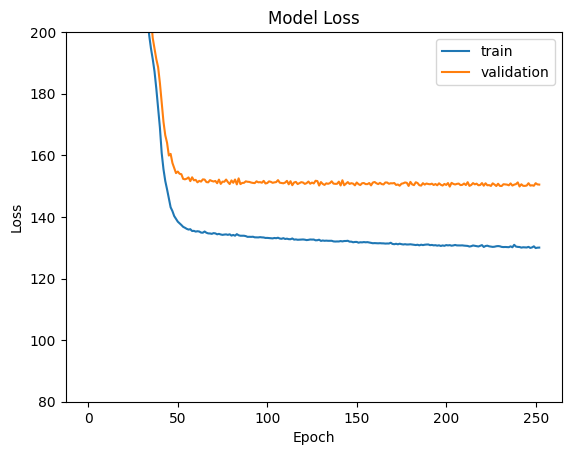

In [ ]:
# Visualiza la pérdida durante el entrenamiento

plt.title('Model Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.ylim(80, 200)
plt.show()

In [ ]:
# Definimos el yhat y redondeamos a número entero porque no puede haber 1,4 accidentes es 1 o 2
yhat = np.round(modelo.predict(X_test))
# cantidad de predicciones, 1 porque es un modelo de regresión
yhat.shape

12/12 [==============================] - 1s 2ms/step


(358, 1)

In [ ]:
# Media de accidentes de todos los distritos 
df_distrito["numero_accidentes"].mean()

35.65260497667185

In [ ]:
# Métricas para evaluar el modelo de regresión

r2 = r2_score(y_test, yhat)
mae = mean_absolute_error(y_test, yhat)
mse = mean_squared_error(y_test, yhat)
rmse = np.sqrt(mean_squared_error(y_test, yhat))
linear_model = [[str(modelo), modelo, r2, mae, mse, rmse]]
df_metricas_regresion = pd.DataFrame(data = linear_model, columns = ["nombre", "modelo", "r2", "mae", "mse", "rmse"])
df_metricas_regresion

# Falla por 9 accidentes

nombre   
0  <keras.src.engine.sequential.Sequential object...  \

                                              modelo       r2       mae   
0  <keras.src.engine.sequential.Sequential object...  0.27097  9.553073  \

          mse       rmse  
0  140.821229  11.866812

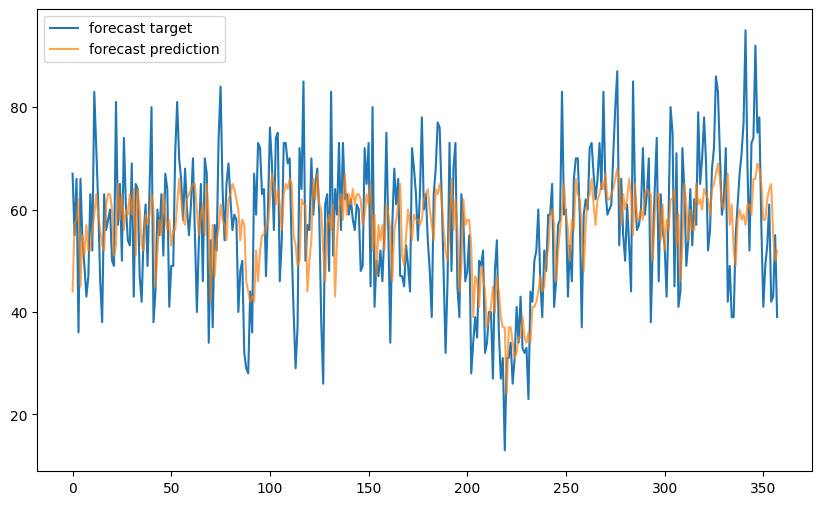

In [ ]:
plt.figure(figsize=(10, 6))  
plt.plot(y_test, label="forecast target")  
plt.plot(yhat.flatten(), label="forecast prediction", alpha=0.7)  
plt.legend()
plt.show() 

In [ ]:
df = pd.DataFrame({'Datos de prueba': y_test, 'Prediccion': yhat.flatten()})

fig = px.line(df, labels = {'index': 'Range'}, title = 'Comparación de Datos de Prueba y Predicciones')

fig.update_layout(title_x = 0.5)
fig.show()

# CONCLUSION

Nuestros resultados del modelo no son nada prometedores. El modelo solo explica el 27% de los datos.

Las predicciones del modelo tienen un error absoluto de 9 accidentes en comparación con los valores reales.

Estos resultados muestran que el modelo tiene cierta capacidad para predecir el número de accidentes, pero aún hay margen de mejora, especialmente considerando la variabilidad observada en los datos. 

Si nuestro modelo fuera más preciso, podría contribuir a la implementación de medidas proactivas para mejorar la seguridad en las carreteras y reducir el número de accidentes, aunque el EDA da claves muy relevantes para ello. 

Nuestra conclusión final es que nuestro modelo es como el vino, creemos que mejorará con el tiempo y unos datos más estables. 